# Lemmatization et Tokenization

In [50]:
import json
import re
import numpy as np
from pprint import pprint
import pandas as pd
import requests
import nltk.data
import matplotlib.pyplot as plt
from french_lefff_lemmatizer.french_lefff_lemmatizer import FrenchLefffLemmatizer

In [2]:
class JSONObject:
     def __init__(self, d):
         self.__dict__ = d

In [3]:
with open("articles_Accuracy.json", "r") as read_file:
    data = read_file.read()
    obj = json.loads(data,object_hook=JSONObject)

In [4]:
len(obj)

11791

In [5]:
print(obj[1].__dict__)

{'title_fr': 'Chéraute Loto des AEL Le loto des Amis de l’Ecole Laïque aura lieu le vendredi...', 'body_en': '', 'body': '', 'date_of_publication': '16 November 2017', 'title_en': '', 'source': 'La République des Pyrénées', 'body_fr': 'Chéraute Loto des AEL Le loto des Amis de l’Ecole Laïque aura lieu le vendredi 17 novembre, à 21 h, à la salle polyvalente de Chéraute. Neuf parties classiques, partie pour les enfants avec une tablette à gagner, loto souletin et deux parties spéciales Nombreux lots : filets garnis et bons d’achats dont un gros lot de 800 €. Ouverture des portes à 20 h. Salle chauffée. Buvette et boissons chaudes. Mauléon Présentation de livre Kepa Etxandi et Michel Duvert ont publié un livre/photos sur les linteaux de portes au Pays Basque. Ils le présenteront le samedi 2 décembre, à 10h, à Xibero Bio à Mauléon. Ce livre est un plaidoyer pour la conservation et la mise en valeur de ces pierres sculptées. Les maisons souletines en possèdent beaucoup mais elles sont malhe

In [6]:
## stopword dictionary
from nltk.corpus import stopwords
stopworddic = set(stopwords.words('french'))
article=['a','au','aux','un','une','le','la','les','de','du','des','ce','cet','cette','ces','son','sa','ses','leur','leurs','mon','ma','mes','ton','ta','tes','notre','notres','votre','votres']
pronom=['où','dont','ça','je','tu','il','elle','nous','vous','ils','elles','on','y','en','se','que','qui','quoi','comment','quand','pourquoi']
coordination=['mais','ou','et','donc','or','ni','car','ne']
v=['avoir','aller','être','faire']
prop=['selon','outre','après','dans','sur','dessus','sous','chez','hors','à','dehors','devant','derrière','avant','arrière','par','entre','parmi','avec','ici','là','bas','pour','pendant','depuis','voilà','dès','aussitôt']
adv=['pas','rien','personne','plus','aucun','jamais','nul','aussi','déjà']
conj=['comme','si','lorsque','tel']
stopworddic.update(set(article),set(pronom),set(coordination),set(v),set(prop),set(adv),set(conj))

In [7]:
## lemmatization
lemmatizer = FrenchLefffLemmatizer()
def lemma(word):
    a=lemmatizer.lemmatize(word,'all')
    b=[x[1] for x in a]
    if 'nc' in b:
        return lemmatizer.lemmatize(word,'n')
    if 'v' in b:
        return lemmatizer.lemmatize(word,'v')
    return lemmatizer.lemmatize(word)

In [8]:
## tokenization
def tokenize(article):
    rawtokens=nltk.word_tokenize(article)
    metokens = [w.lower() for w in rawtokens if re.search('[a-zA-ZàâäèéêëîïôœùûüÿçÀÂÄÈÉÊËÎÏÔŒÙÛÜŸÇ]+',w)]
    latokens=[]
    for str in metokens:
        if(re.search(r'\w+\'',str)):
            str=re.sub(r'\w+\'', '', str) 
        latokens.append(str)
    pre_tokens = [w for w in latokens if w not in stopworddic]
    return [lemma(w) for w in pre_tokens if lemma(w) not in stopworddic]

# Classification

In [13]:
def is_french(obj):
    return (obj.body_en == ''and not obj.body_fr == '')

In [10]:
token_text=[tokenize(w.body_fr) for w in obj if is_french(w)]

In [11]:
len(token_text)

7844

In [14]:
from gensim import corpora, models
import gensim

In [15]:
dictionary = corpora.Dictionary(token_text)
corpus = [dictionary.doc2bow(text) for text in token_text]
tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

In [55]:
dictionary.save('dictionary.dict')
corpora.MmCorpus.serialize('corpus.mm', corpus_tfidf)

In [16]:
lda = models.ldamodel.LdaModel(corpus_tfidf, id2word = dictionary, num_topics = 20,passes=20)

In [18]:
lda.save('lda.model')

In [17]:
print("LDA Model:")
 
for idx in range(20):
    # Print the first 20 most representative topics
    print("Topic #%s:" % idx, lda.print_topic(idx, 10))
 
print("=" * 20)

LDA Model:
Topic #0: 0.001*"1kubator" + 0.001*"sigfox" + 0.001*"perche" + 0.001*"jérôme" + 0.001*"raouti" + 0.001*"chehih" + 0.001*"baloge" + 0.000*"cce" + 0.000*"sicoval" + 0.000*"abeille"
Topic #1: 0.004*"médiation" + 0.003*"victime" + 0.003*"17h" + 0.003*"indre" + 0.003*"12h" + 0.002*"adavim" + 0.002*"prince" + 0.002*"adavimawanadoo.fr" + 0.002*"nécrologiques" + 0.002*"droit"
Topic #2: 0.002*"ecole" + 0.002*"icade" + 0.001*"responsable" + 0.001*"design" + 0.001*"graduate" + 0.001*"cs" + 0.001*"ensci" + 0.001*"desmoulins" + 0.001*"incubator" + 0.001*"iae"
Topic #3: 0.002*"sap" + 0.001*"drone" + 0.001*"cmn" + 0.001*"modiface" + 0.001*"meuse" + 0.001*"sésame" + 0.001*"voler" + 0.001*"grand-ducal" + 0.001*"maquillage" + 0.000*"smd"
Topic #4: 0.001*"5g" + 0.001*"upvd" + 0.000*"real" + 0.000*"sapin" + 0.000*"lorente" + 0.000*"adp" + 0.000*"isf" + 0.000*"estate" + 0.000*"taxation" + 0.000*"perpignan"
Topic #5: 0.001*"leroy" + 0.001*"merlin" + 0.001*"russie" + 0.001*"technowest" + 0.001*"ta

In [20]:
from gensim.models import LdaModel
loading = LdaModel.load('lda.model')

In [21]:
thetas=[loading[c] for c in corpus_tfidf]

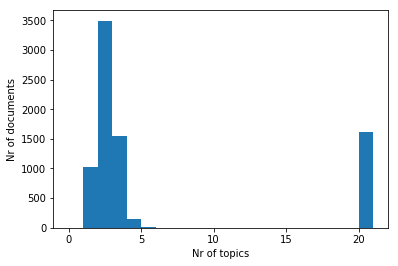

In [22]:
plt.hist([len(t) for t in thetas], np.arange(22))
plt.ylabel('Nr of documents')
plt.xlabel('Nr of topics')
plt.show()

In [27]:
def pre_new(doc):
    split = tokenize(doc)
    return dictionary.doc2bow(split)

In [49]:
new = pd.DataFrame(loading[pre_new(obj[3005].body_fr)],columns=['id','prob']).sort_values('prob',ascending=False)
new['topic'] = new['id'].apply(loading.print_topic)
new

,id,prob,topic
0,17,0.891933,"0.002*""start-up"" + 0.002*""projet"" + 0.002*""ent..."
1,18,0.058034,"0.002*""3d"" + 0.002*""maladie"" + 0.002*""professe..."


In [53]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

In [56]:
d = gensim.corpora.Dictionary.load('dictionary.dict')
c = gensim.corpora.MmCorpus('corpus.mm')

In [57]:
data = pyLDAvis.gensim.prepare(loading, c, d)
data

C:\Users\ZTY\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
17    -0.427483  0.007143       1        1  79.283638
18     0.048587  0.116633       2        1   4.687829
1      0.017861 -0.022504       3        1   1.368030
8      0.025661 -0.012790       4        1   1.176200
6      0.024677 -0.011396       5        1   1.099492
7      0.024042 -0.009552       6        1   1.031980
12     0.023087 -0.008465       7        1   0.956559
2      0.011770 -0.007870       8        1   0.942684
14     0.020406 -0.006144       9        1   0.858499
3      0.022166 -0.006309      10        1   0.852005
13     0.021868 -0.005815      11        1   0.847043
0      0.021802 -0.004988      12        1   0.836090
16     0.021995 -0.005729      13        1   0.832161
10     0.021049 -0.004135      14        1   0.799162
11     0.020771 -0.003619      15        1   0.765826
5      0.020907 -0.003940      16        1   0.761003
19     0.019889 -0.003218      17        1   0.739908
15     0.020544 -0.002868      18        1   0.738805
4      0.020291 -0.002617      19        1   0.723135
9      0.020109 -0.001818      20        1   0.699952, topic_info=      Category       Freq              Term      Total  loglift  logprob
term                                                                    
329    Default  39.000000              aide  39.000000  30.0000  30.0000
195    Default  55.000000       association  55.000000  29.0000  29.0000
1174   Default  30.000000             accès  30.000000  28.0000  28.0000
2305   Default  32.000000       responsable  32.000000  27.0000  27.0000
1591   Default  26.000000             droit  26.000000  26.0000  26.0000
88     Default  34.000000             lundi  34.000000  25.0000  25.0000
316    Default  39.000000          vendredi  39.000000  24.0000  24.0000
285    Default  36.000000             porte  36.000000  23.0000  23.0000
278    Default  22.000000        permanence  22.000000  22.0000  22.0000
3222   Default  22.000000            design  22.000000  21.0000  21.0000
5667   Default  22.000000               tél  22.000000  20.0000  20.0000
79     Default  92.000000        innovation  92.000000  19.0000  19.0000
1043   Default  35.000000            ouvert  35.000000  18.0000  18.0000
611    Default  49.000000           conseil  49.000000  17.0000  17.0000
221    Default  13.000000             ecole  13.000000  16.0000  16.0000
2016   Default  26.000000         marseille  26.000000  15.0000  15.0000
7366   Default  18.000000        incubation  18.000000  14.0000  14.0000
2326   Default  45.000000               rue  45.000000  13.0000  13.0000
4234   Default  14.000000             utile  14.000000  12.0000  12.0000
295    Default  72.000000         pépinière  72.000000  11.0000  11.0000
1377   Default  23.000000                by  23.000000  10.0000  10.0000
1042   Default  22.000000                of  22.000000   9.0000   9.0000
3604   Default  34.000000           digital  34.000000   8.0000   8.0000
2009   Default  18.000000        management  18.000000   7.0000   7.0000
1883   Default  27.000000          institut  27.000000   6.0000   6.0000
967    Default  42.000000          business  42.000000   5.0000   5.0000
4162   Default  13.000000     départemental  13.000000   4.0000   4.0000
1189   Default  17.000000           adresse  17.000000   3.0000   3.0000
600    Default  17.000000                co  17.000000   2.0000   2.0000
2115   Default  19.000000              open  19.000000   1.0000   1.0000
...        ...        ...               ...        ...      ...      ...
23473  Topic20   0.212954           algérie   0.413006   4.2995  -7.7932
20920  Topic20   0.201935             poool   0.401987   4.2734  -7.8463
8344   Topic20   0.451424            beauté   0.967472   4.1996  -7.0419
6523   Topic20   0.174943     masschallenge   0.374994   4.1995  -7.9898
24691  Topic20   0.222964           pepsico   0.482414   4.1901  -7.